# Imports libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,SimpleRNN,GRU,Bidirectional,LSTM,Dense,Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re

2025-04-26 12:17:17.794314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745669837.992110      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745669838.049991      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Datasets

In [5]:
with bz2.BZ2File("/kaggle/input/amazonreviews/train.ft.txt.bz2") as f:
    training_data =[f.readline().decode('utf-8').strip() for _ in range(12000)]

In [6]:
with bz2.BZ2File("/kaggle/input/amazonreviews/test.ft.txt.bz2") as f:
    test_data=[f.readline().decode('utf-8').strip() for _ in range(2500)]

In [7]:
print("Training data subset size:", len(training_data))
print("Testing data subset size :", len(test_data))

Training data subset size: 12000
Testing data subset size : 2500


In [8]:
training_data[0:5]

['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 '__label__2 Amazing!: This sound

In [9]:
test_data[0:5]

['__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too ma

# Preparing Dataset

In [10]:
training_labels=[int(re.findall(r'__label__(\d)',line)[0]) for line in training_data]
training_texts=[re.sub(r'__label__\d','',line) for line in training_data]

test_labels=[int(re.findall(r'__label__(\d)',line)[0] ) for line in test_data]
test_texts=[re.sub(r'__label__\d','',line) for line in test_data]

In [11]:
training_labels=[0 if label ==1  else 1 for label in training_labels]
test_labels=[0 if label ==1  else 1 for label in test_labels]

In [12]:
print(test_labels[:4])

[1, 1, 0, 1]


In [13]:
print("\n\n",test_texts[:4])



 [' Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', " One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds 

# Text Cleaning

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.preprocessing.sequence import pad_sequences


In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
def clean_text(text):
    ps=PorterStemmer()
    stop_words=set(stopwords.words("english"))

    text=text.lower()
    text=re.sub(r"^a-z\s",'',text)
    words=text.split()
    # tokenize and remove stopwords , apply stemming
    words=[ps.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

In [17]:
training_texts=[clean_text(text) for text in training_texts]
test_texts=[clean_text(text) for text in test_texts]

In [18]:
training_texts[0]

'stune even non-gamer: sound track beautiful! paint seneri mind well would recomend even peopl hate vid. game music! play game chrono cross game ever play best music! back away crude keyboard take fresher step grate guitar soul orchestras. would impress anyon care listen! ^_^'

# Tokenization

In [19]:
max_words=1000
max_sequence_length=100
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_texts)

In [20]:
X_train=tokenizer.texts_to_sequences(training_texts)
X_test=tokenizer.texts_to_sequences(test_texts)

In [21]:
X_train=pad_sequences(X_train,maxlen=max_sequence_length)
X_test=pad_sequences(X_test,maxlen=max_sequence_length)

In [22]:
X_train=np.array(X_train)
print(X_train.shape)
X_test=np.array(X_test)
print(X_test.shape)
y_train=np.array(training_labels)
print(y_train.shape)
y_test=np.array(test_labels)
print(y_test.shape)

(12000, 100)
(2500, 100)
(12000,)
(2500,)


# Training RNN

In [23]:
model=Sequential([
    Embedding(input_dim=max_words,output_dim=300,input_length=max_sequence_length),
    SimpleRNN(128,return_sequences=True,dropout=0.3),
    LayerNormalization(),
    SimpleRNN(128,dropout=0.3),#Second RNN layer
    LayerNormalization(),
    Dropout(0.3),
    
    Dense(64,activation='relu'),# Extra dense layer
    Dropout(0.2),
    Dense(1,activation='sigmoid') # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745669863.046257      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=5e-5),
    metrics=['accuracy']
)

In [25]:
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [27]:
history = model.fit(
    X_train, 
    y_train,
    epochs=50,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/50


I0000 00:00:1745669880.676177      92 service.cc:148] XLA service 0x7fc95000e550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745669880.676682      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745669881.323675      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/24 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5182 - loss: 0.8245 

I0000 00:00:1745669884.607456      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.5034 - loss: 0.8313 - val_accuracy: 0.5188 - val_loss: 0.7089
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4992 - loss: 0.7888 - val_accuracy: 0.5200 - val_loss: 0.6949
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5050 - loss: 0.7624 - val_accuracy: 0.5368 - val_loss: 0.6897
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5262 - loss: 0.7284 - val_accuracy: 0.5404 - val_loss: 0.6864
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5067 - loss: 0.7280 - val_accuracy: 0.5440 - val_loss: 0.6852
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5038 - loss: 0.7268 - val_accuracy: 0.5460 - val_loss: 0.6844
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5166 - loss: 0.7143 - val_accuracy: 0.5608 - val_loss: 0.6856
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5232 - loss: 0.7098 - val_accuracy: 0.5628 - val_loss: 

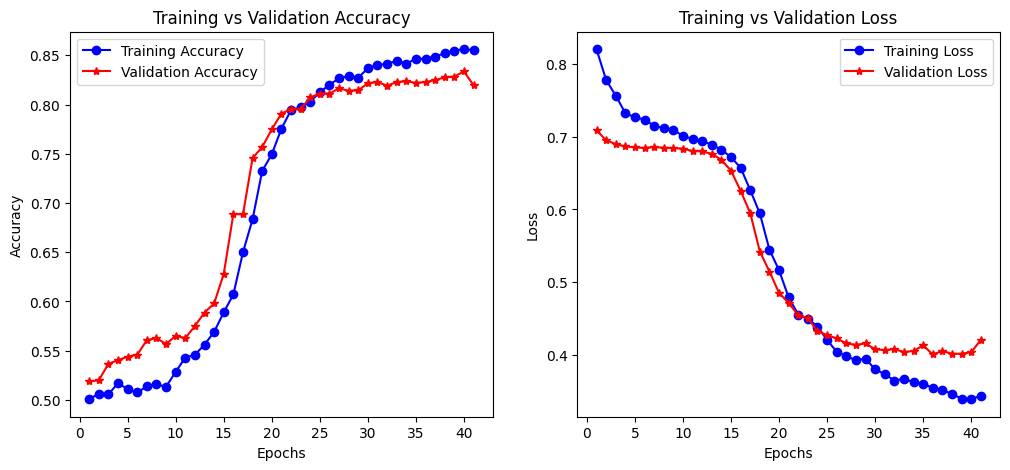

In [28]:
# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [29]:

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Confusion Matrix:
[[ 980  211]
 [ 232 1077]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1191
           1       0.84      0.82      0.83      1309

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



# Training LSTM

In [30]:
# Define improved model
model1 = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),  # Added recurrent dropout
    LayerNormalization(),  # Added normalization for stability
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),  
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 466ms/step - accuracy: 0.5162 - loss: 0.8233 - val_accuracy: 0.5664 - val_loss: 0.6766
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.5572 - loss: 0.7061 - val_accuracy: 0.6392 - val_loss: 0.6526
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.6088 - loss: 0.6608 - val_accuracy: 0.6724 - val_loss: 0.6290
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.6373 - loss: 0.6394 - val_accuracy: 0.7056 - val_loss: 0.5844
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - accuracy: 0.6842 - loss: 0.5932 - val_accuracy: 0.7280 - val_loss: 0.5391
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.7290 - loss: 0.5377 - val_accuracy: 0.7608 - val_loss: 0.5010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.7624 - loss: 0.4949 - val_accuracy: 0.7736 - val_loss: 0.4739
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.7821 - loss: 0.4715 - val_accuracy: 0.787

# Model Evaluation

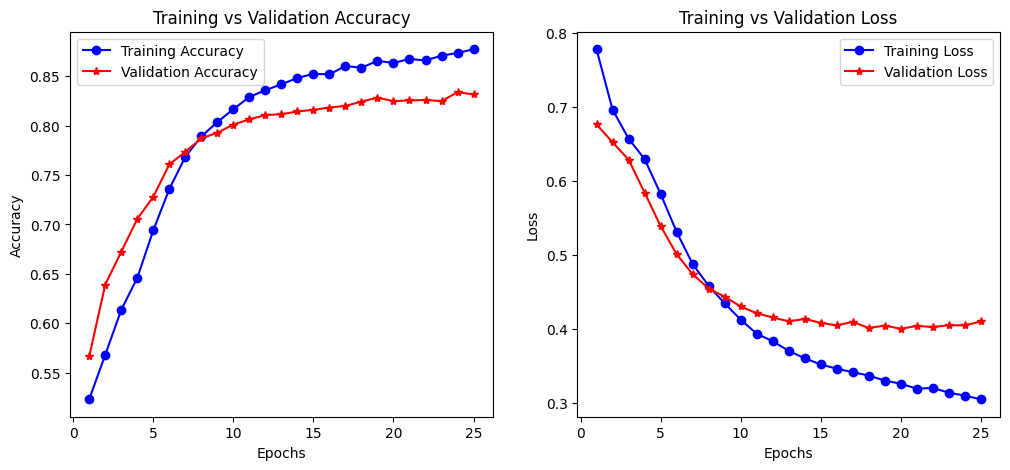

In [31]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(1, len(history1.history['accuracy']) + 1)
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [32]:
# Evaluate with a confusion matrix and classification report
y_pred = model1.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step
Confusion Matrix:
[[ 953  238]
 [ 200 1109]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1191
           1       0.82      0.85      0.84      1309

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



# Training GRU

In [35]:
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # GRU layer with dropout
    LayerNormalization(),  # Added normalization for stability
    GRU(128, dropout=0.3, recurrent_dropout=0.2),  # Second GRU layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history2= model2.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 361ms/step - accuracy: 0.5067 - loss: 0.8433 - val_accuracy: 0.5020 - val_loss: 0.7803
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.5032 - loss: 0.8241 - val_accuracy: 0.5108 - val_loss: 0.7730
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - accuracy: 0.5008 - loss: 0.8227 - val_accuracy: 0.5140 - val_loss: 0.7671
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - accuracy: 0.5017 - loss: 0.8109 - val_accuracy: 0.5100 - val_loss: 0.7616
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.5155 - loss: 0.8005 - val_accuracy: 0.5128 - val_loss: 0.7570
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.4861 - loss: 0.8041 - val_accuracy: 0.5116 - val_loss: 0.7537
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.5004 - loss: 0.7894 - val_accuracy: 0.5156 - val_loss: 0.7512
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.4942 - loss: 0.7844 - val_accuracy: 0.5124 - val

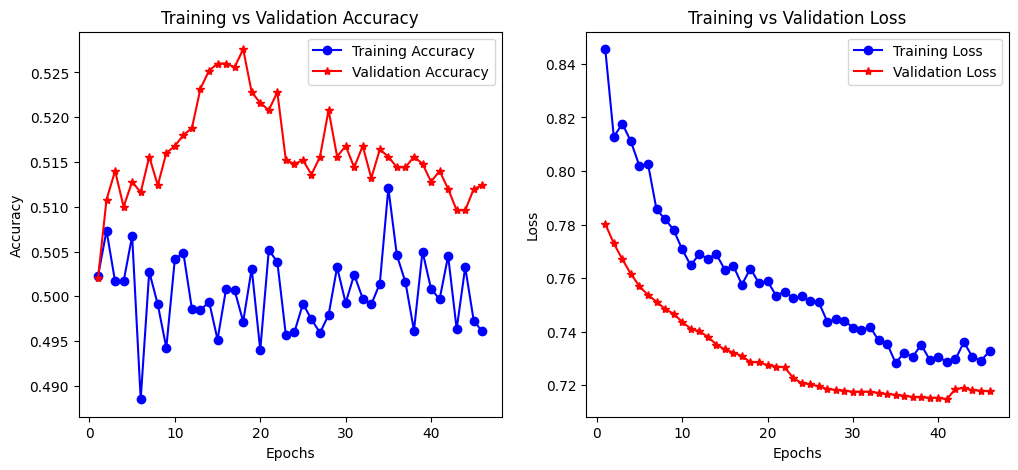

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[ 980  211]
 [ 232 1077]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1191
           1       0.84      0.82      0.83      1309

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



In [36]:
# Extract values from history
epochs = range(1, len(history2.history['accuracy']) + 1)
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()



# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Detection System

### for RNN model

In [37]:

def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiment
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Positive 😊 (Confidence: 0.6416)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Negative 😡 (Confidence: 0.2418)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Negative 😡 (Confidence: 0.3708)



### for LSTM model

In [38]:

def predict_sentiment(text, model1, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model1.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiment
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model1, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Positive 😊 (Confidence: 0.8140)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Negative 😡 (Confidence: 0.1678)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Negative 😡 (Confidence: 0.2011)



### for GRU model

In [39]:

def predict_sentiment(text, model2, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model2.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiment
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model2, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Negative 😡 (Confidence: 0.4223)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Positive 😊 (Confidence: 0.5223)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Positive 😊 (Confidence: 0.6049)



In [42]:
model1.save("LSTM_model.h5")  # Saves architecture, weights & optimizer


import pickle

with open("LSTM.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [43]:
import tensorflow as tf
print(tf.__version__)

2.18.0
